# <center> African Credit Scoring Challenge</center>

<p align="center">
    <img src="https://www.digest.tz/wp-content/uploads/2024/11/dfeb749b-962d-4e6c-8fb0-33f54ceaffd5_880x660.webp" width="50%" height="50%">
</p>

<p style="text-align:justify">Financial institutions need to predict loan defaults to mitigate risk and optimise lending decisions. In Africa’s rapidly growing financial markets, with diverse customer demographics and dynamic economic conditions, accurately assessing default risk is more important than ever.

In this challenge, we want you to develop a robust, generalisable machine learning model to predict the likelihood of loan defaults for both existing customers and new applicants. Beyond accurate predictions, we encourage yous to innovate by incorporating unique factors relevant to each financial market.

The objective of this challenge is to develop a machine learning model that accurately predicts the probability of loan default.

The top 10 winners, in addition to submitting their solution, will need to design and submit a credit scoring function, using their model's outputs and probabilities. This step involves binning model outputs into risk categories and proposing a scalable credit risk score.

By accurately predicting loan defaults, your work will enable the client organisation to create a credit scoring solution to evaluate risk more effectively, improving decisionmaking, reducing financial losses associated with high-risk lending, and allowing for expansion into new financial markets.

The challenge provider is a private asset manager that operates in several financial markets across Africa.
</p>

The train dataset contains 68654 entries with 16 categorical/symbolic attributes, whereas the test set contains 18594 entries. In dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The list of variables are:


0. **ID**: A unique identifier for each entry in the dataset.

1. **customer_id**: Unique identifier for each customer in the dataset.

2. **country_id**: Identifier or code representing the country where the customer resides or where the loan was issued.

3. **tbl_loan_id**: Unique identifier for each loan associated with the customer.

4. **Total_Amount**: The total loan amount initially disbursed to the customer.

5. **Total_Amount_to_Repay**: The total amount the customer is expected to repay, including principal, interest, and fees.

6. **loan_type**: The category or type of loan.

7. **disbursement_date**: The date when the loan amount was disbursed to the customer.

8. **duration**: The length of the loan term, typically expressed in days

9. **lender_id**: Unique identifier for the lender or institution that issued the loan.

10. **New_versus_Repeat**: Indicates whether the loan is the customer's first loan ("New") or if the customer has taken loans before ("Repeat").

11. **Amount_Funded_By_Lender**: The portion of the loan funded directly by the lender.

12. **Lender_portion_Funded**: Percentage of the total loan amount funded by the lender.

13. **due_date**: The date by which the loan repayment is due.

14. **Lender_portion_to_be_repaid**: The portion of the outstanding loan that needs to be repaid to the lender.

15. **target**: This variables takes the value 0 or 1. 1 means the customer defaulted on the loan, whereas 0 means, the customer paid the loan.


## Libraries

In [162]:
import os, random, sys, time, warnings 
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import humanize
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from rgf.sklearn import RGFClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import RidgeClassifier


# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features
from plotly.subplots import make_subplots
import datetime as dt
import plotly.express as px


In [4]:
seed = 2022
np.random.seed(seed)
random.seed(seed)

## Reading Data

In [5]:
# Loading the train dataset
path="../Data/"
train = pd.read_csv(path+'Train.csv')
test = pd.read_csv(path+'Test.csv')
economic_indicators = pd.read_csv(path+'economic_indicators.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape, "Economic Indicators", economic_indicators.head(), economic_indicators.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

'Economic Indicators'

,Country,Indicator,YR2001,YR2002,YR2003,YR2004,YR2005,YR2006,YR2007,YR2008,...,YR2014,YR2015,YR2016,YR2017,YR2018,YR2019,YR2020,YR2021,YR2022,YR2023
0,Ghana,"Inflation, consumer prices (annual %)",41.509496,9.360932,29.772980,18.042739,15.438992,11.679184,10.734267,16.494640,...,15.489616,17.149970,17.454635,12.371922,7.808765,7.143640,9.887290,9.971089,31.255895,38.106966
1,Cote d'Ivoire,"Inflation, consumer prices (annual %)",4.361529,3.077265,3.296807,1.457988,3.885830,2.467191,1.892006,6.308528,...,0.448682,1.251500,0.723178,0.685881,0.359409,-1.106863,2.425007,4.091952,5.276167,4.387117
2,Kenya,"Inflation, consumer prices (annual %)",5.738598,1.961308,9.815691,11.624036,10.312778,14.453734,9.758880,26.239817,...,6.878155,6.582154,6.297250,8.005650,4.689806,5.239638,5.405162,6.107936,7.659863,7.671396
3,Ghana,"Official exchange rate (LCU per US$, period av...",0.716305,0.792417,0.866764,0.899495,0.905209,0.915107,0.932619,1.052275,...,2.896575,3.714642,3.909817,4.350533,4.585325,5.217367,5.595708,5.805700,8.272400,11.020408
4,Cote d'Ivoire,"Official exchange rate (LCU per US$, period av...",732.397693,693.713226,579.897426,527.338032,527.258363,522.425625,478.633718,446.000041,...,493.757330,591.211698,592.605615,580.656750,555.446458,585.911013,575.586005,554.530675,623.759701,606.569750


(27, 25)

## Basic EDA

### Data Quality

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [7]:
test.isna().sum()

ID                             0
customer_id                    0
country_id                     0
tbl_loan_id                    0
lender_id                      0
loan_type                      0
Total_Amount                   0
Total_Amount_to_Repay          0
disbursement_date              0
due_date                       0
duration                       0
New_versus_Repeat              0
Amount_Funded_By_Lender        0
Lender_portion_Funded          0
Lender_portion_to_be_repaid    0
dtype: int64

In [8]:
economic_indicators.isna().sum()

Country       0
Indicator     0
YR2001        7
YR2002        7
YR2003        7
YR2004        7
YR2005        3
YR2006        3
YR2007        3
YR2008        3
YR2009        3
YR2010        3
YR2011        3
YR2012        3
YR2013        3
YR2014        3
YR2015        6
YR2016        6
YR2017        6
YR2018       10
YR2019       10
YR2020       10
YR2021       10
YR2022       13
YR2023       13
dtype: int64

In [9]:
train.duplicated().sum()

0

In [10]:
test.duplicated().sum()

0

In [11]:
economic_indicators.duplicated().sum()

0

### Univariate analysis

#### Target 

In [12]:
trace0 = go.Bar(
            x = train[train["target"]== 1]["target"].value_counts().index.values,
            y = train[train["target"]== 1]["target"].value_counts().values,
            name='Defaulted on loan (Bad credit)'
    )

trace1 = go.Bar(
            x = train[train["target"]== 0]["target"].value_counts().index.values,
            y = train[train["target"]== 0]["target"].value_counts().values,
            name='Paid the loan (Good credit)'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='target Variable'
    ),
    title='Default variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

- 1258 customers defaulted on their loan in the past years within the train set.

#### Total_Amount

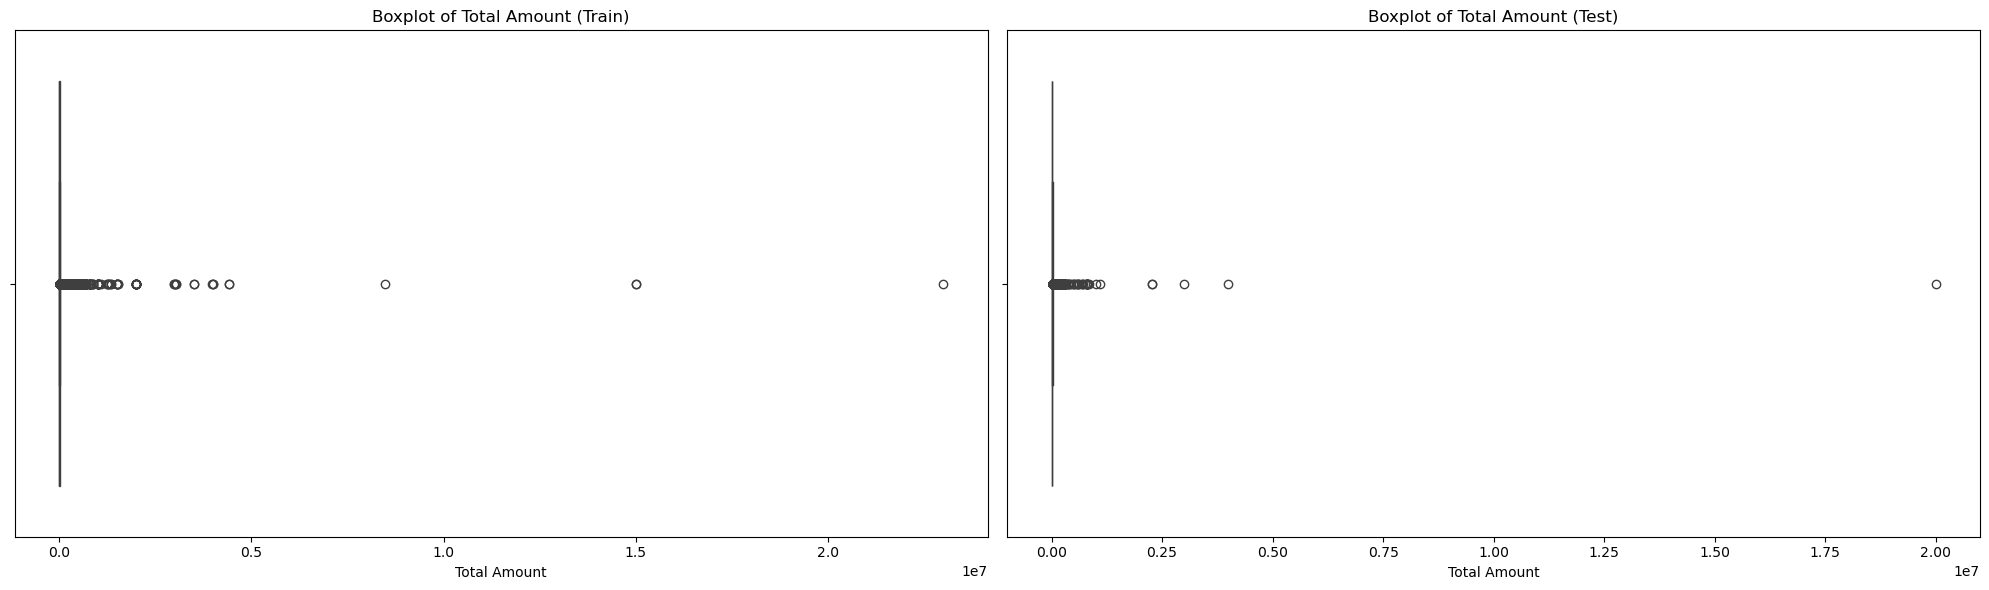

In [36]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create a boxplot for Total_Amount in the train dataset
sns.boxplot(x=train['Total_Amount'], ax=ax1)
ax1.set_xlabel('Total Amount')
ax1.set_title('Boxplot of Total Amount (Train)')

# Create a boxplot for Total_Amount in the test dataset
sns.boxplot(x=test['Total_Amount'], ax=ax2)
ax2.set_xlabel('Total Amount')
ax2.set_title('Boxplot of Total Amount (Test)')

plt.tight_layout()
plt.show()

In [14]:
train.loc[train['Total_Amount'] > 5000000] 

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
33103,ID_259638306534267277,259638,Kenya,306534,267277,Type_15,8472742.0,9509002.91,2023-02-09,2023-08-11,183,Repeat Loan,9000.0,0.001062,10101.0,1
43860,ID_248114119236245684,248114,Kenya,119236,245684,Type_15,15000000.0,19748939.00,2022-02-23,2023-08-25,548,Repeat Loan,10000.0,0.000667,13166.0,0
54972,ID_249695306184267277,249695,Kenya,306184,267277,Type_15,23000000.0,25415000.00,2022-12-20,2023-06-20,182,Repeat Loan,1700.0,0.000074,1878.0,1
59939,ID_262968290977267277,262968,Kenya,290977,267277,Type_15,15000000.0,18493296.00,2022-10-28,2023-04-26,180,Repeat Loan,600000.0,0.040000,739732.0,1


In [15]:
test.loc[test['Total_Amount'] > 5000000] 

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
10568,ID_248114262971267277,248114,Kenya,262971,267277,Type_15,20000000.0,24152842.0,2022-09-20,2025-01-16,849,Repeat Loan,1000.0,0.00005,1208.0


In [19]:
train.loc[train['Total_Amount'] < 10] 

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
2023,ID_306247367092267278,306247,Kenya,367092,267278,Type_7,5.0,6.0,2024-06-24,2024-07-01,7,Repeat Loan,3.0,0.6,4.0,0
3449,ID_306247367022251804,306247,Kenya,367022,251804,Type_7,5.0,6.0,2024-06-20,2024-06-27,7,Repeat Loan,1.0,0.2,1.0,0
5730,ID_306247366912267278,306247,Kenya,366912,267278,Type_7,5.0,6.0,2024-06-14,2024-06-21,7,Repeat Loan,3.0,0.6,4.0,0
12084,ID_306454366974251804,306454,Kenya,366974,251804,Type_7,5.0,6.0,2024-06-19,2024-06-26,7,Repeat Loan,1.0,0.2,1.0,0
30203,ID_306454366974267278,306454,Kenya,366974,267278,Type_7,5.0,6.0,2024-06-19,2024-06-26,7,Repeat Loan,3.0,0.6,4.0,0
34156,ID_306247367022267278,306247,Kenya,367022,267278,Type_7,5.0,6.0,2024-06-20,2024-06-27,7,Repeat Loan,3.0,0.6,4.0,0
37936,ID_306247367188267278,306247,Kenya,367188,267278,Type_7,5.0,6.0,2024-06-27,2024-07-04,7,Repeat Loan,3.0,0.6,4.0,0
41868,ID_306454366500251804,306454,Kenya,366500,251804,Type_7,5.0,6.0,2024-05-13,2024-05-20,7,Repeat Loan,1.0,0.2,1.0,0
42608,ID_306247367188251804,306247,Kenya,367188,251804,Type_7,5.0,6.0,2024-06-27,2024-07-04,7,Repeat Loan,1.0,0.2,1.0,0
43166,ID_306247366945267278,306247,Kenya,366945,267278,Type_7,2.0,3.0,2024-06-18,2024-06-25,7,Repeat Loan,2.0,1.0,3.0,0


In [18]:
test.loc[test['Total_Amount'] <10] 

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
6658,ID_306247366912251804,306247,Kenya,366912,251804,Type_7,5.0,6.0,2024-06-14,2024-06-21,7,Repeat Loan,1.0,0.2,1.0
13743,ID_306247367092251804,306247,Kenya,367092,251804,Type_7,5.0,6.0,2024-06-24,2024-07-01,7,Repeat Loan,1.0,0.2,1.0


In [33]:
pd.DataFrame(test.Total_Amount.describe().apply(lambda x: humanize.intword(x)))

,Total_Amount
count,18.6 thousand
mean,14.5 thousand
std,156.9 thousand
min,5
25%,2.1 thousand
50%,4.7 thousand
75%,10.3 thousand
max,20.0 million


In [34]:
pd.DataFrame(train.Total_Amount.describe().apply(lambda x: humanize.intword(x)))

,Total_Amount
count,68.7 thousand
mean,14.8 thousand
std,141.6 thousand
min,2
25%,2.3 thousand
50%,5.2 thousand
75%,11.4 thousand
max,23.0 million


- `Type_15` loans have a huge total amount (above 5 million)
- `Type_7` loans have a low total amount (below 10)
- The average total loan amount initially disbursed to the customer is `14.8 thousand` with a standard deviation of `141.6 thousand`
- 

#### Total Amount to repay

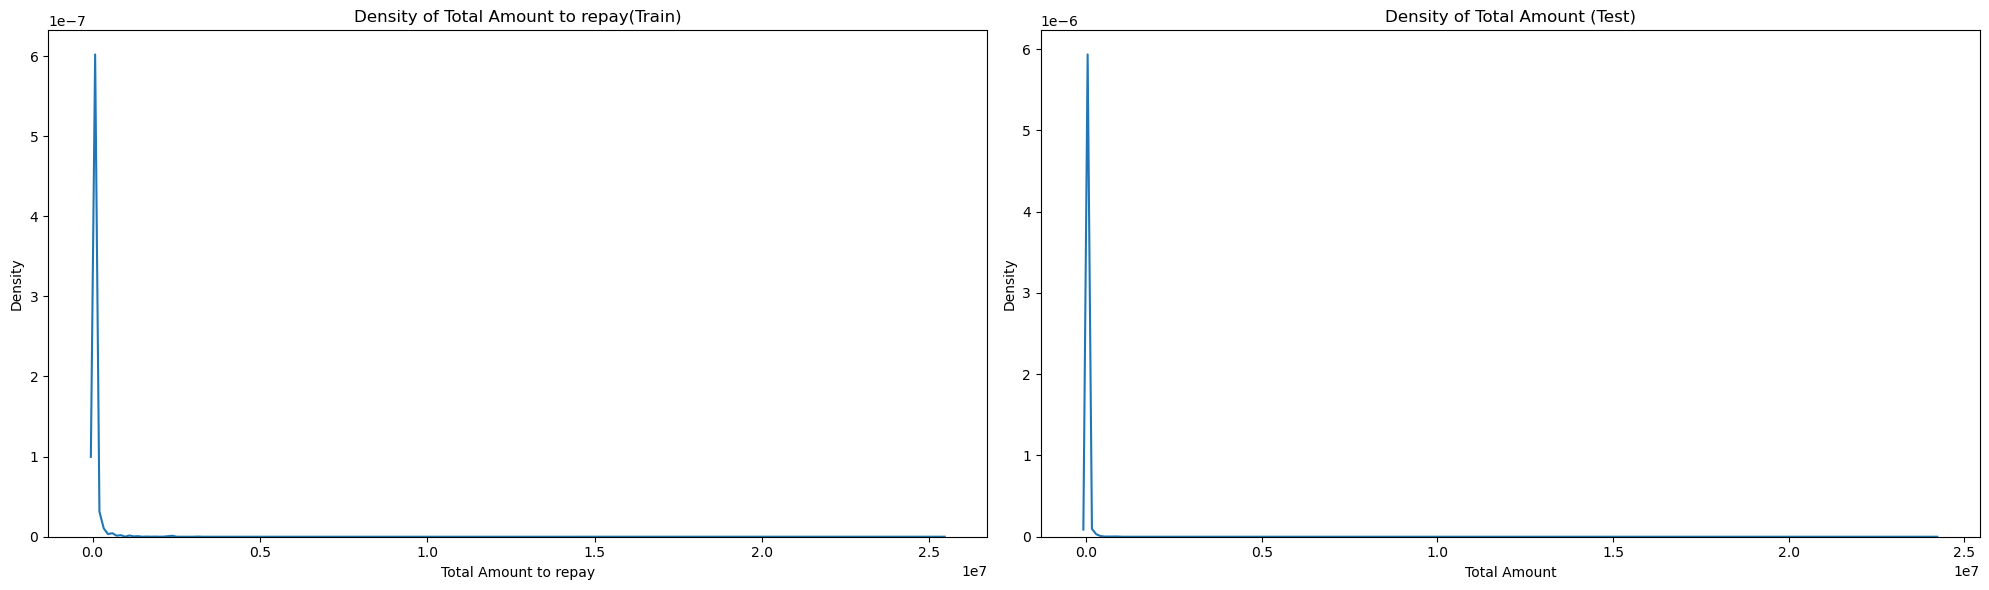

In [38]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create a boxplot for Total_Amount in the train dataset
sns.kdeplot(x=train['Total_Amount_to_Repay'], ax=ax1)
ax1.set_xlabel('Total Amount to repay')
ax1.set_title('Density of Total Amount to repay(Train)')

# Create a boxplot for Total_Amount in the test dataset
sns.kdeplot(x=test['Total_Amount_to_Repay'], ax=ax2)
ax2.set_xlabel('Total Amount')
ax2.set_title('Density of Total Amount (Test)')

plt.tight_layout()
plt.show()

In [39]:
pd.DataFrame(train.Total_Amount_to_Repay.describe().apply(lambda x: humanize.intword(x)))

,Total_Amount_to_Repay
count,68.7 thousand
mean,15.6 thousand
std,165.1 thousand
min,0
25%,2.3 thousand
50%,5.3 thousand
75%,11.7 thousand
max,25.4 million


In [41]:
pd.DataFrame(test.Total_Amount_to_Repay.describe().apply(lambda x: humanize.intword(x)))

,Total_Amount_to_Repay
count,18.6 thousand
mean,15.8 thousand
std,187.2 thousand
min,0
25%,2.2 thousand
50%,4.8 thousand
75%,10.6 thousand
max,24.2 million


#### Category or type of loan

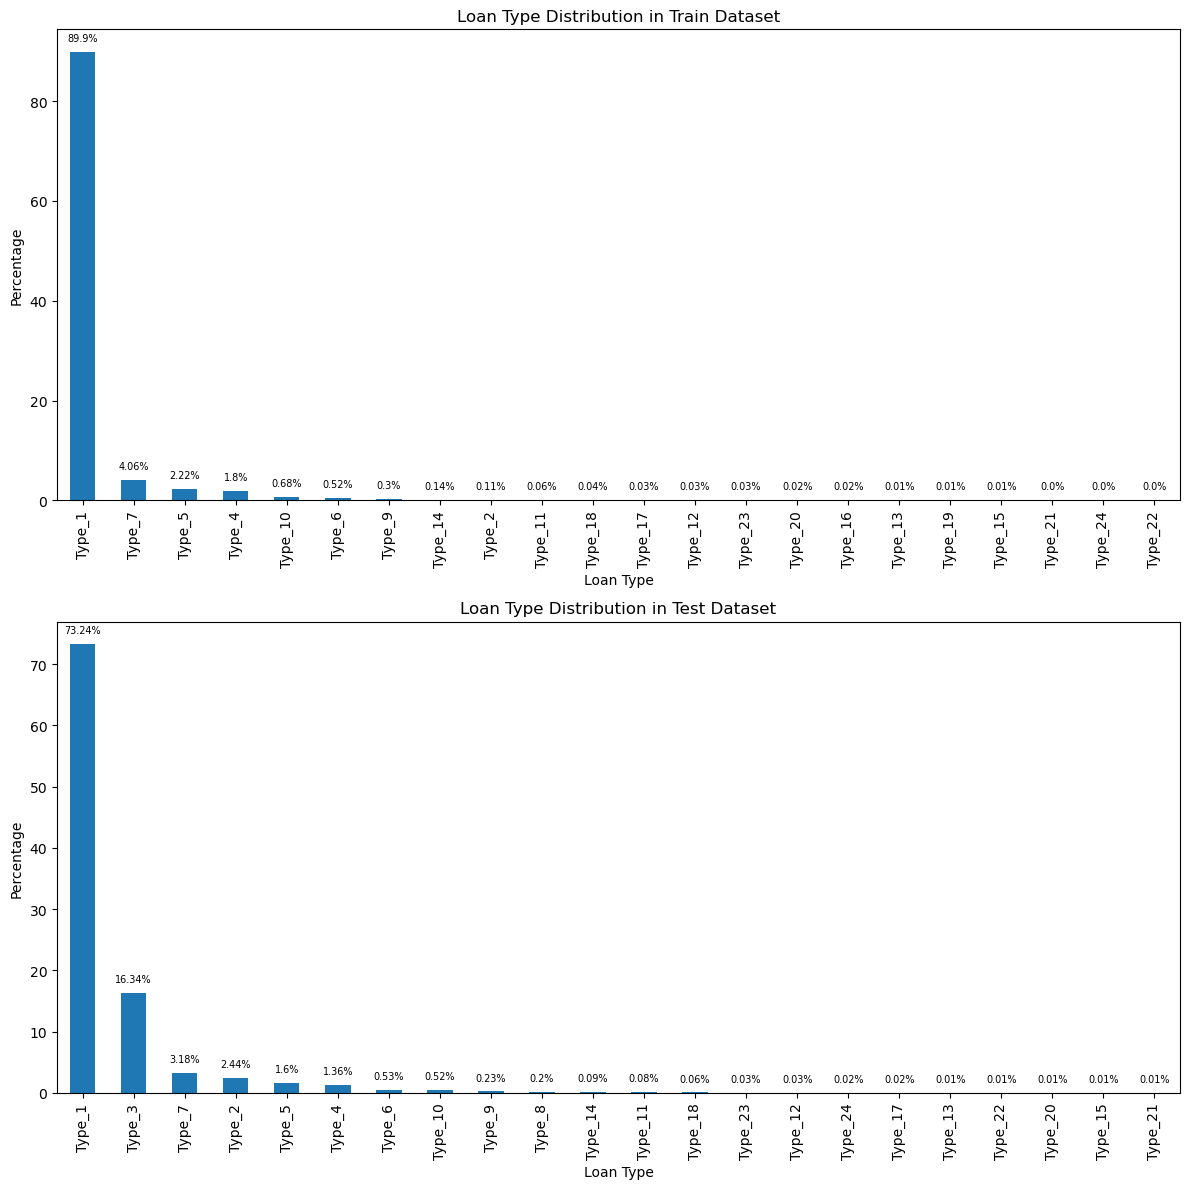

In [56]:
# Calculate the percentage distribution of loan types for train dataset
train_loan_type_distribution = round(train["loan_type"].value_counts(normalize=True) * 100, 2)

# Calculate the percentage distribution of loan types for test dataset
test_loan_type_distribution = round(test["loan_type"].value_counts(normalize=True) * 100, 2)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Create a bar plot for train dataset
train_loan_type_distribution.plot(kind='bar', ax=ax1, title='Loan Type Distribution in Train Dataset')
ax1.set_xlabel('Loan Type')
ax1.set_ylabel('Percentage')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Add percentages above the bars for train dataset
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=7)

# Create a bar plot for test dataset
test_loan_type_distribution.plot(kind='bar', ax=ax2, title='Loan Type Distribution in Test Dataset')
ax2.set_xlabel('Loan Type')
ax2.set_ylabel('Percentage')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

# Add percentages above the bars for test dataset
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=7)

plt.tight_layout()
plt.show()

- Most of the loans ar of types 1, 3, and 7.
- `Type_15` loans represent 0.01%
- `Type_3` loans are not present in the train set.

#### Disbursement date

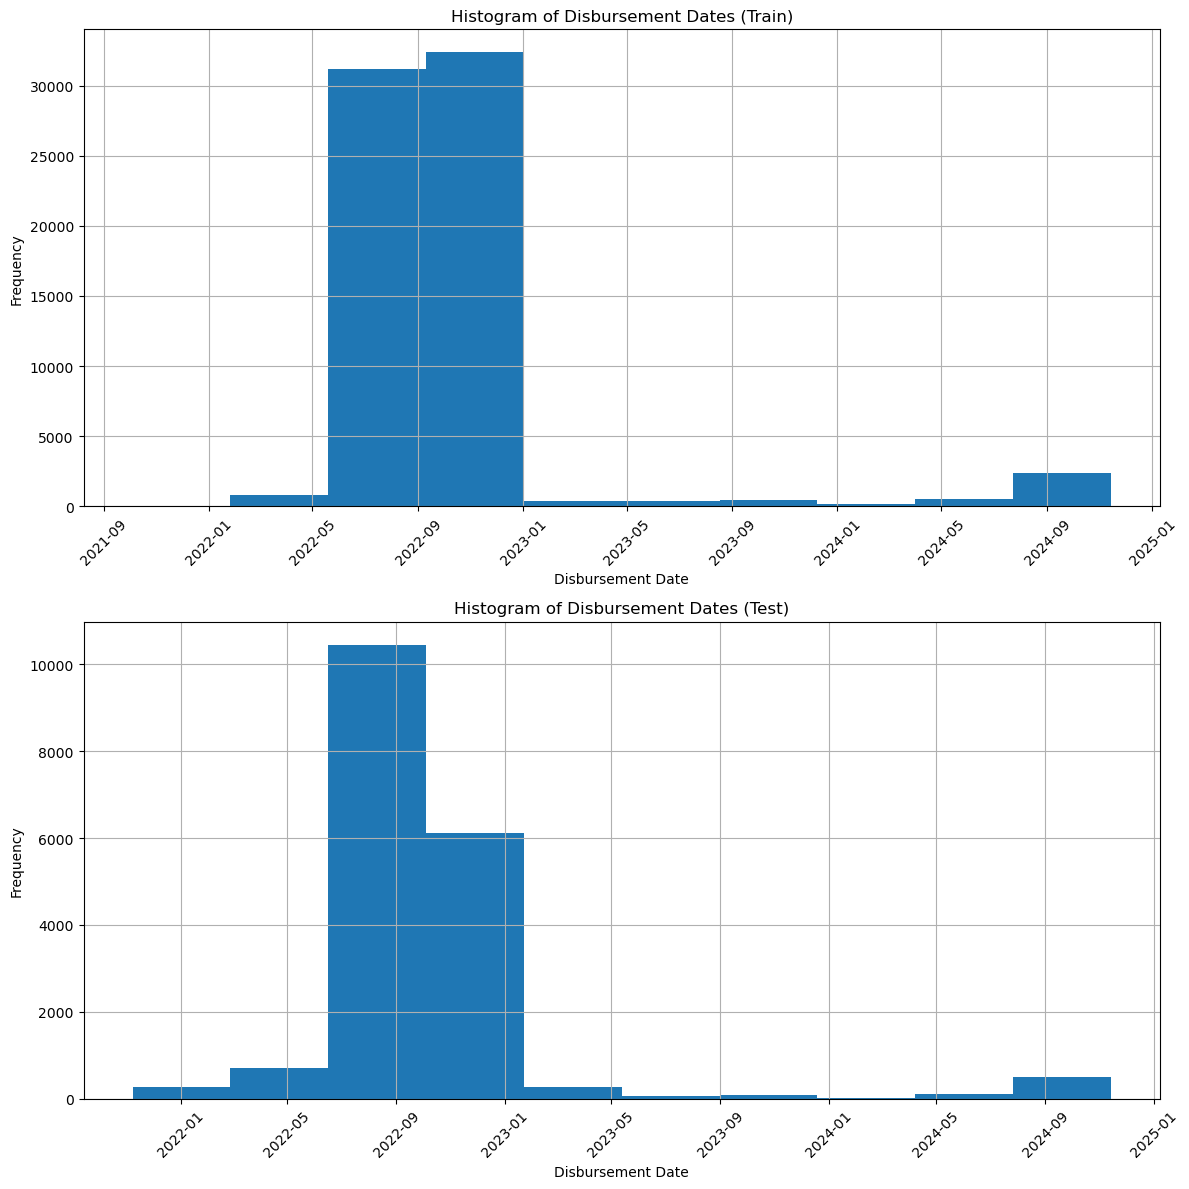

In [60]:
# Convert disbursement_date to datetime
train['disbursement_date'] = pd.to_datetime(train['disbursement_date'])
test['disbursement_date'] = pd.to_datetime(test['disbursement_date'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Create a histogram of disbursement_date for train dataset
train['disbursement_date'].hist(ax=ax1)
ax1.set_xlabel('Disbursement Date')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Disbursement Dates (Train)')
ax1.tick_params(axis='x', rotation=45)

# Create a histogram of disbursement_date for test dataset
test['disbursement_date'].hist(ax=ax2)
ax2.set_xlabel('Disbursement Date')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Disbursement Dates (Test)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [59]:
pd.DataFrame(train['disbursement_date'].describe().apply(lambda x: humanize.naturaldate(x)))

,disbursement_date
count,68654
mean,Oct 17 2022
min,Oct 04 2021
25%,Aug 10 2022
50%,Sep 16 2022
75%,Oct 24 2022
max,Nov 14


- The dates when the loan amount was disbursed to the customer are between October, 17th 2022 and November, 14th 2024.
- Most of the loans within the train set are disbursed around September, 2022.

#### Duration

In [77]:
train["dataset"] = "train"
test["dataset"] = "test"
duration_description = pd.concat([train, test], axis=0).groupby("dataset")["duration"].describe()
duration_description["count"] = duration_description["count"].apply(lambda x: humanize.intcomma(int(x)))
duration_description["max"] = duration_description["max"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["min"] = duration_description["min"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["mean"] = duration_description["mean"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["std"] = duration_description["std"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["25%"] = duration_description["25%"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["50%"] = duration_description["50%"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description["75%"] = duration_description["75%"].apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x)))
duration_description

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,"18,594",13 days,a month,a day,7 days,7 days,7 days,2 years
train,"68,654",8 days,13 days,a day,7 days,7 days,7 days,3 years


- The average duration of the loans is `13 days` in train set with a standard deviation of `1 month` and `9 days` in the test set with a standard deviation of `13 days`;
- There are customers who take loans only for `a day`;
- The maximum duration of the loans is `2 years` in the test and `3 years` in the train;


#### Lender or Institution

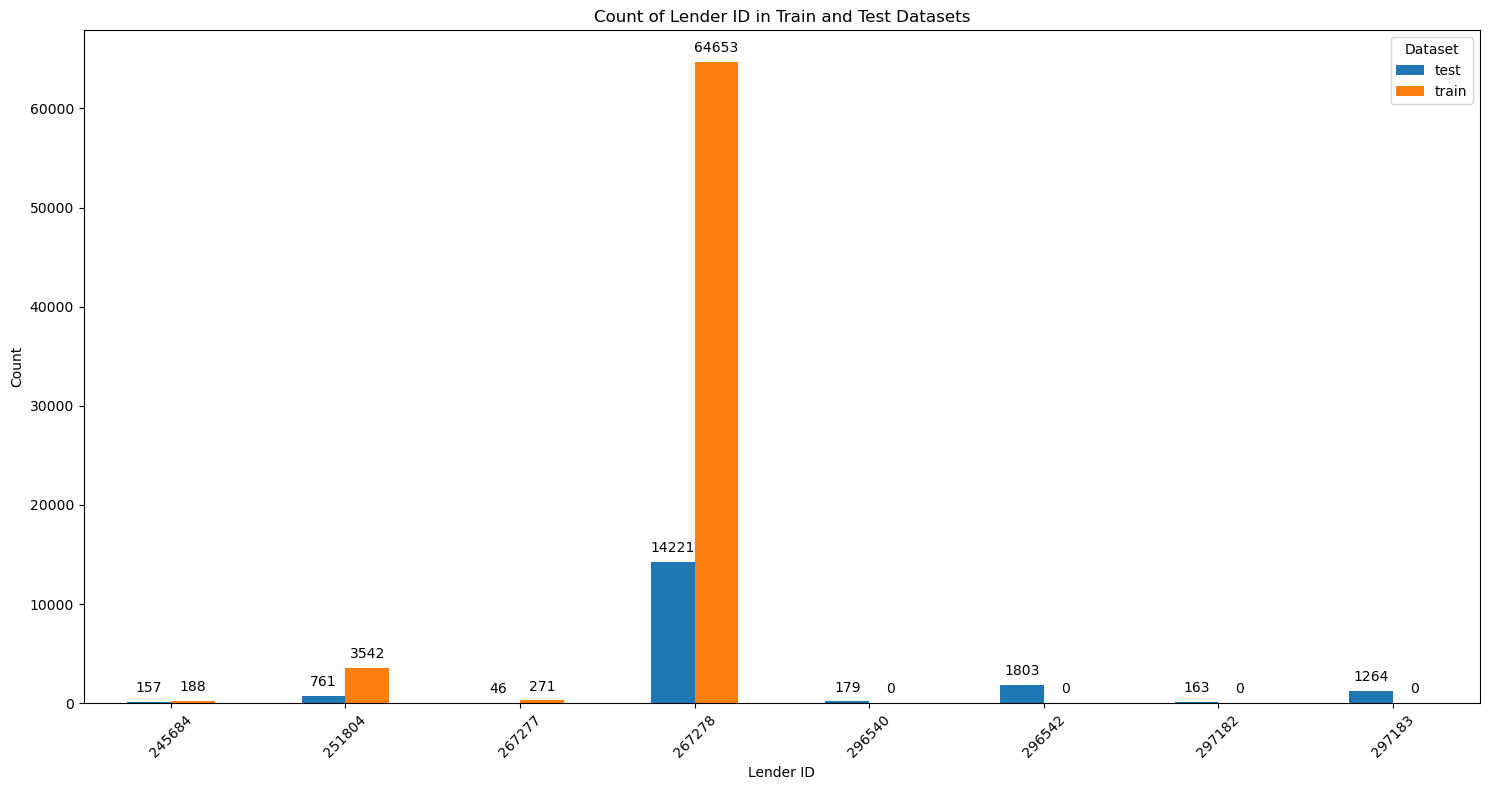

In [88]:
# Concatenate the datasets
combined = pd.concat([train, test], axis=0)

# Group by lender_id and dataset, and count the occurrences
grouped = combined.groupby(['lender_id', 'dataset']).size().unstack(fill_value=0)

# Create a grouped bar plot
ax = grouped.plot(kind='bar', figsize=(15, 8))
plt.xlabel('Lender ID')
plt.ylabel('Count')
plt.title('Count of Lender ID in Train and Test Datasets')
plt.xticks(rotation=45)
plt.legend(title='Dataset')

# Add labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

- Lenders `267278`, `251804`,  and `245684` are the most present within our dataset;
- There are some lenders who are only present within the test set;

#### New vs Repeat

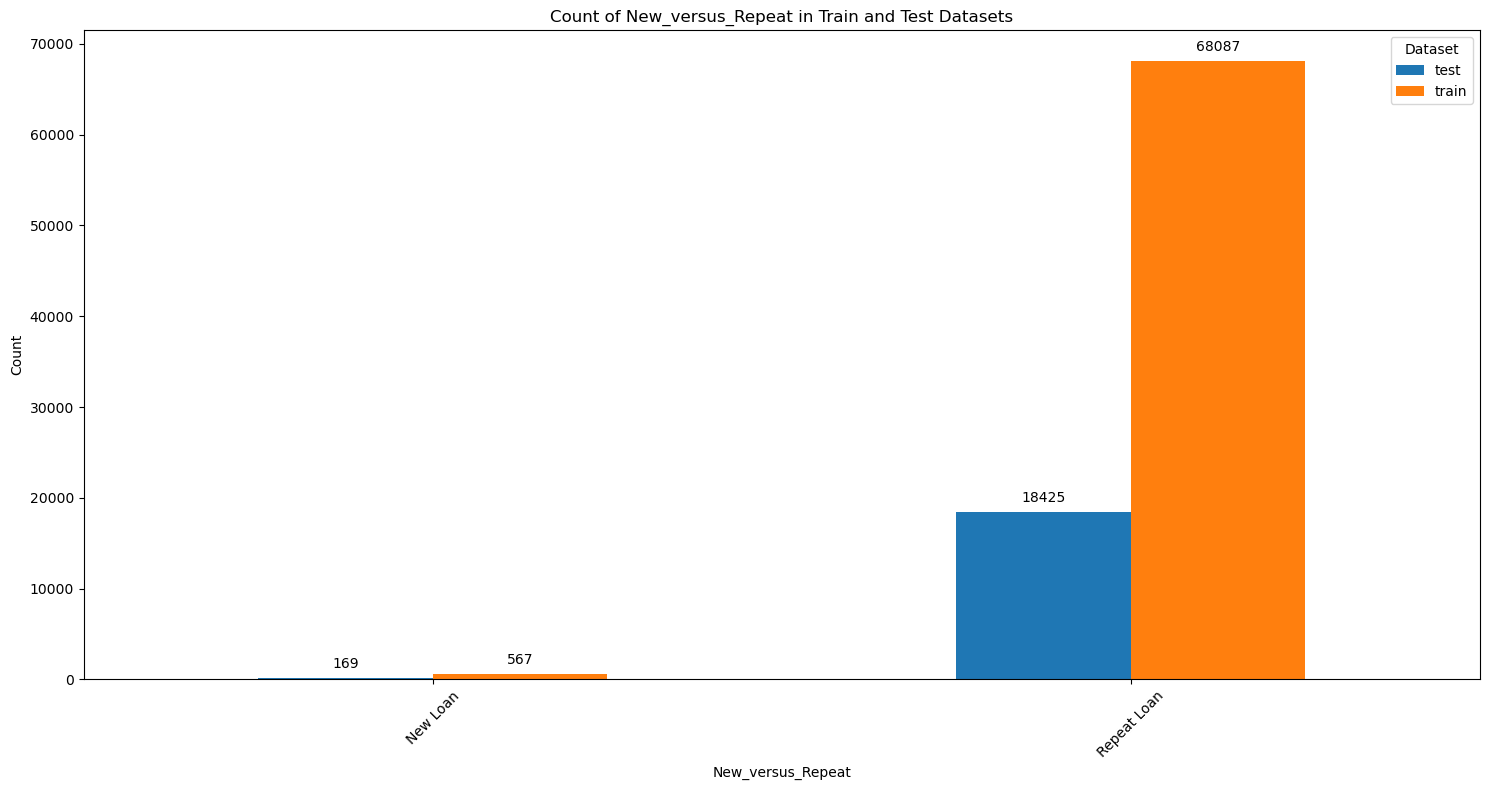

In [89]:
# Concatenate the datasets
combined = pd.concat([train, test], axis=0)

# Group by New_versus_Repeat and dataset, and count the occurrences
grouped = combined.groupby(['New_versus_Repeat', 'dataset']).size().unstack(fill_value=0)

# Create a grouped bar plot
ax = grouped.plot(kind='bar', figsize=(15, 8))
plt.xlabel('New_versus_Repeat')
plt.ylabel('Count')
plt.title('Count of New_versus_Repeat in Train and Test Datasets')
plt.xticks(rotation=45)
plt.legend(title='Dataset')

# Add labels above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.show()

- More loans are given to past customers;

#### Amount_Funded_By_Lender

In [91]:
Amount_Funded_By_Lender_description = pd.concat([train, test], axis=0).groupby("dataset")["Amount_Funded_By_Lender"].describe()
Amount_Funded_By_Lender_description["count"] = Amount_Funded_By_Lender_description["count"].apply(lambda x: humanize.intcomma(int(x)))
Amount_Funded_By_Lender_description["max"] = Amount_Funded_By_Lender_description["max"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["min"] = Amount_Funded_By_Lender_description["min"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["mean"] = Amount_Funded_By_Lender_description["mean"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["std"] = Amount_Funded_By_Lender_description["std"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["25%"] = Amount_Funded_By_Lender_description["25%"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["50%"] = Amount_Funded_By_Lender_description["50%"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description["75%"] = Amount_Funded_By_Lender_description["75%"].apply(lambda x: humanize.intword(x))
Amount_Funded_By_Lender_description

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,"18,594",2.3 thousand,6.8 thousand,0,239,744,2.0 thousand,400.0 thousand
train,"68,654",2.5 thousand,11.9 thousand,0,234,915,2.3 thousand,1.6 million


- Some customers are not funded by the Institution, meaning that the loan demand is rejected (`min=0`);
- The maximum value funded by the institution within the train set is `1.6 million` whereas within the test set, it is `0.4 million`;
- 

#### Lender_portion_Funded

In [111]:
test.loc[test.Lender_portion_Funded==1].duration.describe()

count    32.000000
mean     26.562500
std       7.413751
min       7.000000
25%      30.000000
50%      30.000000
75%      30.000000
max      30.000000
Name: duration, dtype: float64

In [112]:
train.loc[train.Lender_portion_Funded>=1].duration.describe()

count    155.000000
mean      27.193548
std        6.518801
min        7.000000
25%       30.000000
50%       30.000000
75%       30.000000
max       30.000000
Name: duration, dtype: float64

In [115]:
train.loc[train.Lender_portion_Funded>1]

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target,dataset
30684,ID_255356215046267278,255356,Kenya,215046,267278,Type_1,2249.0,2249.0,2022-07-14,2022-07-21,7,Repeat Loan,2627.1,1.168119,2627.0,0,train


In [105]:
Lender_portion_Funded_description = pd.concat([train, test], axis=0).groupby("dataset")["Lender_portion_Funded"].describe()
Lender_portion_Funded_description = round(Lender_portion_Funded_description*100, 1)
Lender_portion_Funded_description["count"] = Lender_portion_Funded_description["count"].apply(lambda x: humanize.intcomma(int(x/100)))
Lender_portion_Funded_description

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,"18,594",20.7,12.2,0.0,13.1,30.0,30.0,100.0
train,"68,654",21.9,13.0,0.0,11.9,30.0,30.0,116.8


- The lenders fund around `20%` of the loan amount on average, with a standard deviation of `12%`;
- `75%` of the customers within our dataset are funded at `30%` by the lenders;
- In the test set, some customers are totally funded by the lenders (**100%**), whereas in the train set, some customers are overfunded: Most of these loans have a short duration(between 7 and 30 days);


#### due_date

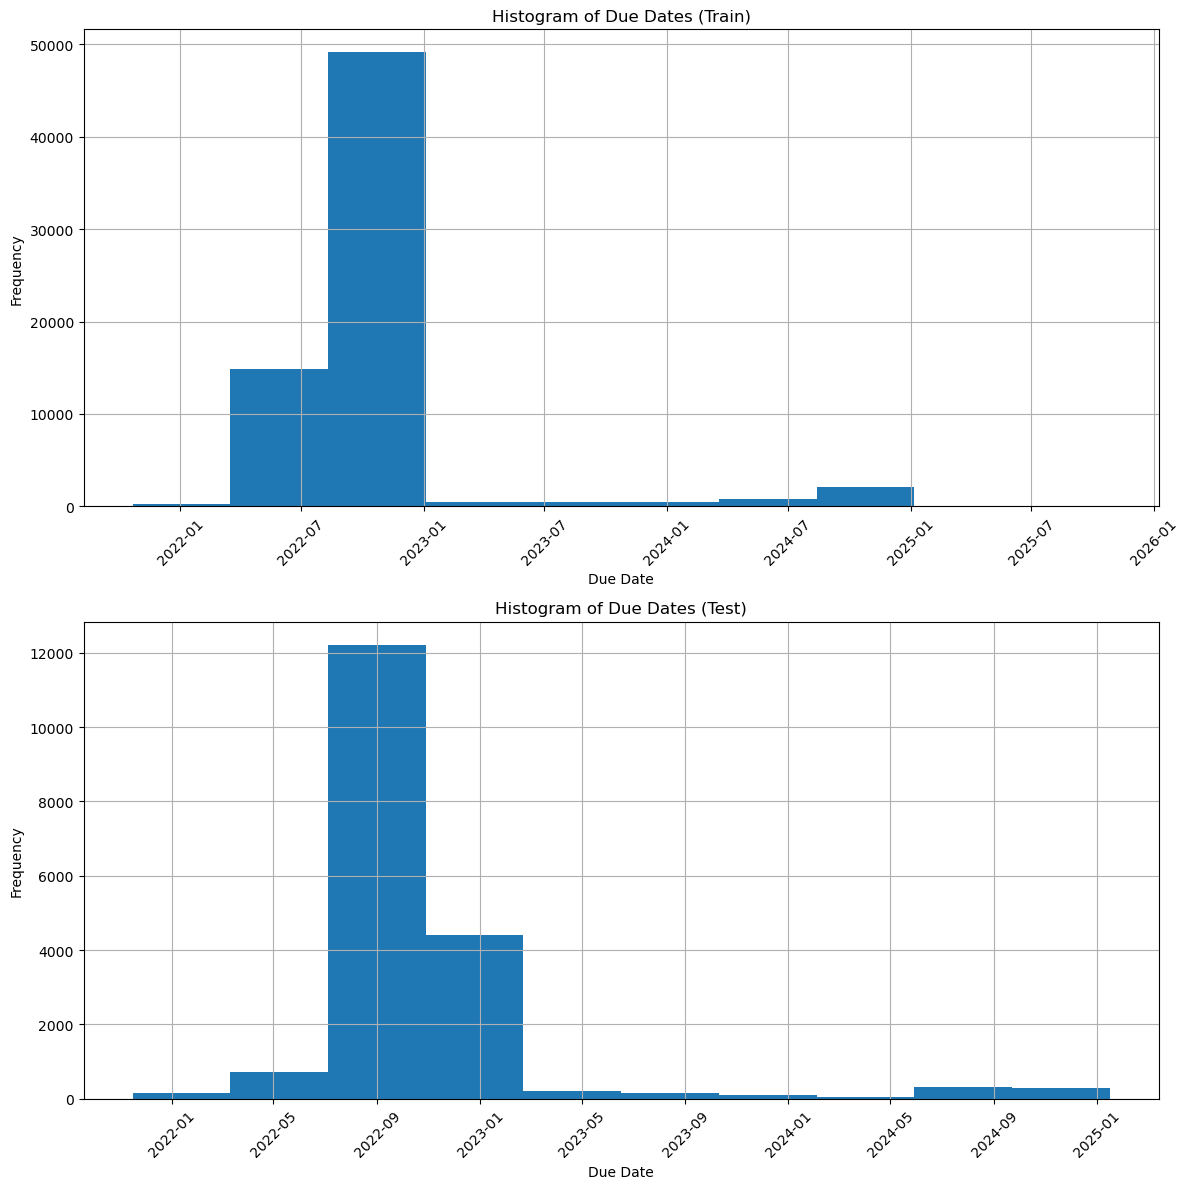

In [116]:
# Convert due_date to datetime
train['due_date'] = pd.to_datetime(train['due_date'])
test['due_date'] = pd.to_datetime(test['due_date'])

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Create a histogram of due_date for train dataset
train['due_date'].hist(ax=ax1)
ax1.set_xlabel('Due Date')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Due Dates (Train)')
ax1.tick_params(axis='x', rotation=45)

# Create a histogram of disbursement_date for test dataset
test['due_date'].hist(ax=ax2)
ax2.set_xlabel('Due Date')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Due Dates (Test)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [121]:
due_date_description = pd.concat([train, test], axis=0).groupby("dataset")['due_date'].describe()
due_date_description["count"] = due_date_description["count"].apply(lambda x: humanize.intcomma(int(x)))
due_date_description["mean"] = due_date_description["mean"].apply(lambda x: humanize.naturaldate(x))
due_date_description["min"] = due_date_description["min"].apply(lambda x: humanize.naturaldate(x))
due_date_description["max"] = due_date_description["max"].apply(lambda x: humanize.naturaldate(x))
due_date_description["25%"] = due_date_description["25%"].apply(lambda x: humanize.naturaldate(x))
due_date_description["50%"] = due_date_description["50%"].apply(lambda x: humanize.naturaldate(x))
due_date_description["75%"] = due_date_description["75%"].apply(lambda x: humanize.naturaldate(x))
due_date_description

,count,mean,min,25%,50%,75%,max
dataset,,,,,,,
test,"18,594",Oct 21 2022,Nov 15 2021,Aug 16 2022,Sep 26 2022,Nov 07 2022,Jan 16
train,"68,654",Oct 25 2022,Oct 21 2021,Aug 17 2022,Sep 23 2022,Oct 31 2022,Oct 27 2025


- The dates when the loan is due to the lender are between October, 21st 2021 and October, 27th 2025 in the train set;

- Most of the loans within the train set are disbursed around September 2022.

#### Lender_portion_to_be_repaid

In [123]:
Lender_portion_to_be_repaid_description = pd.concat([train, test], axis=0).groupby("dataset")["Lender_portion_to_be_repaid"].describe()
Lender_portion_to_be_repaid_description["count"] = Lender_portion_to_be_repaid_description["count"].apply(lambda x: humanize.intcomma(int(x)))
Lender_portion_to_be_repaid_description["max"] = Lender_portion_to_be_repaid_description["max"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["min"] = Lender_portion_to_be_repaid_description["min"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["mean"] = Lender_portion_to_be_repaid_description["mean"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["std"] = Lender_portion_to_be_repaid_description["std"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["25%"] = Lender_portion_to_be_repaid_description["25%"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["50%"] = Lender_portion_to_be_repaid_description["50%"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description["75%"] = Lender_portion_to_be_repaid_description["75%"].apply(lambda x: humanize.intword(x))
Lender_portion_to_be_repaid_description

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,"18,594",2.5 thousand,7.7 thousand,0,244,758,2.0 thousand,423.4 thousand
train,"68,654",2.7 thousand,13.4 thousand,0,239,934,2.3 thousand,1.8 million


- Some loans do not do not need to be repaid to the Institution,as the loan demand is probably rejected (`min=0`);
- The maximum value to be repaid to  the institution within the train set is `1.8 million` whereas within the test set, it is `0.42 million`: these values are a little bit above the maximum value funded by the lender to cover fees and interest;
- 

### Bivariate Analysis

#### Target by Lenders

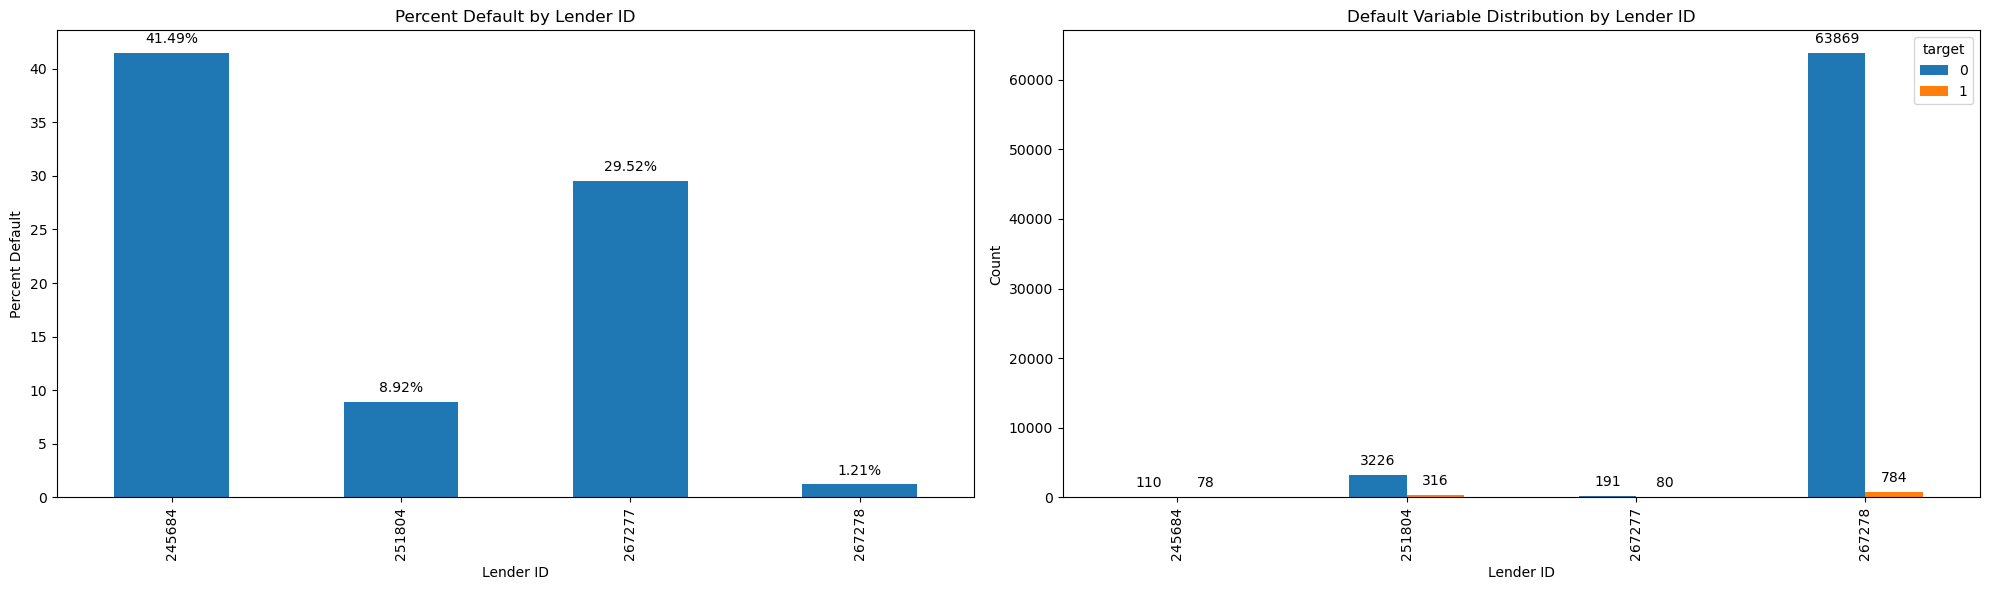

In [45]:
# Calculate the percent default by lender_id
percent_default = train.groupby('lender_id')['target'].mean() * 100

# Group by lender_id and target
grouped = train.groupby(["lender_id", "target"]).size().unstack().fillna(0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot percent default by lender_id
percent_default.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Lender ID')
ax1.set_ylabel('Percent Default')
ax1.set_title('Percent Default by Lender ID')

# Add labels above the bars for percent default plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot the bar chart for default variable distribution by lender_id
grouped.plot(kind='bar', stacked=False, ax=ax2)
ax2.set_xlabel('Lender ID')
ax2.set_ylabel('Count')
ax2.set_title('Default Variable Distribution by Lender ID')

# Add numbers above bars for default variable distribution plot
for p in ax2.patches:
    ax2.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

- Institutions giving more loans, lower their probability of default as their scoring model improves through the years;


#### Target by Anciennety

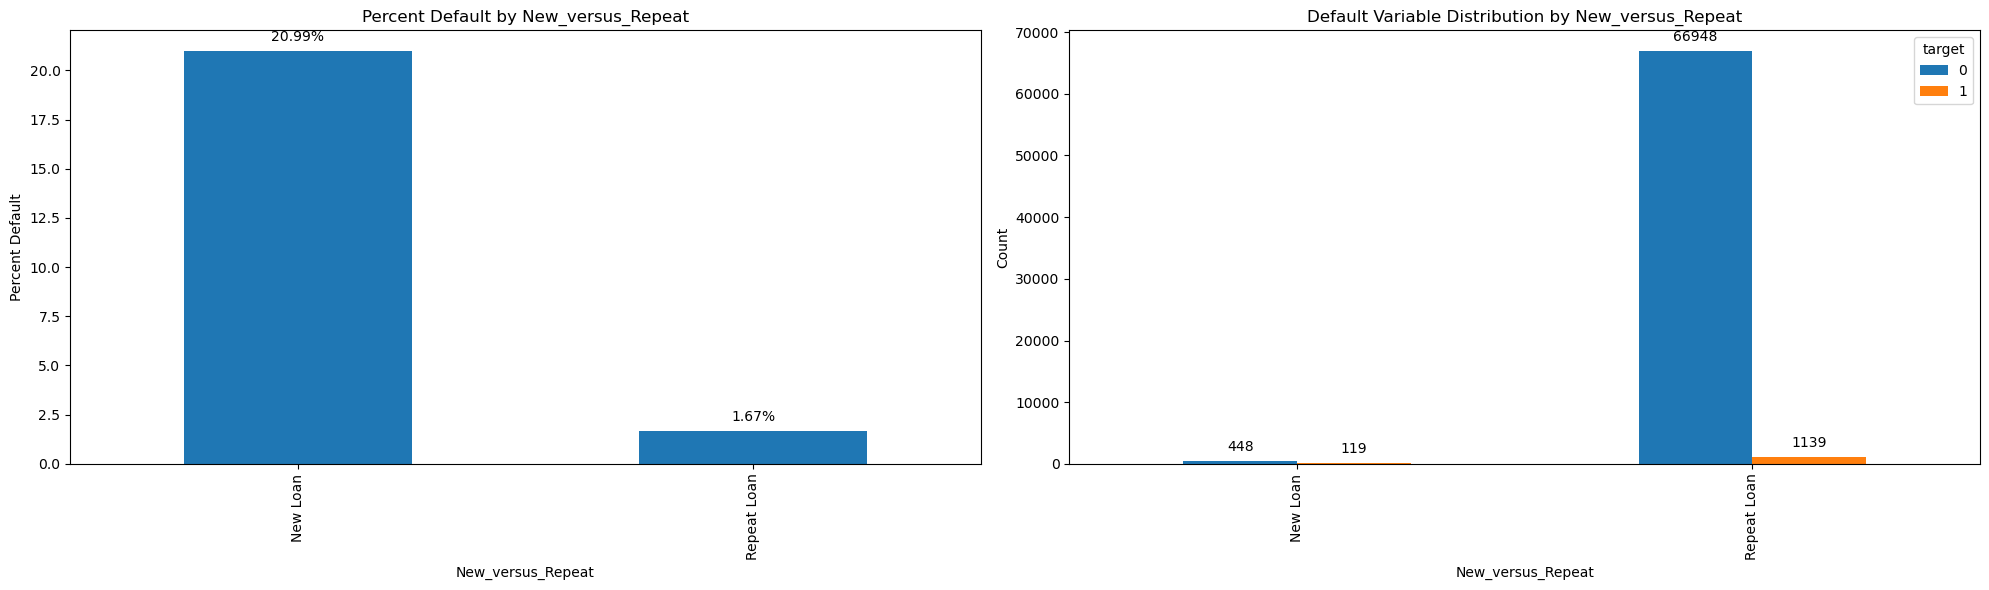

In [46]:
# Calculate the percent default by lender_id
percent_default = train.groupby('New_versus_Repeat')['target'].mean() * 100

# Group by lender_id and target
grouped = train.groupby(["New_versus_Repeat", "target"]).size().unstack().fillna(0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot percent default by New_versus_Repeat
percent_default.plot(kind='bar', ax=ax1)
ax1.set_xlabel('New_versus_Repeat')
ax1.set_ylabel('Percent Default')
ax1.set_title('Percent Default by New_versus_Repeat')

# Add labels above the bars for percent default plot
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot the bar chart for default variable distribution by lender_id
grouped.plot(kind='bar', stacked=False, ax=ax2)
ax2.set_xlabel('New_versus_Repeat')
ax2.set_ylabel('Count')
ax2.set_title('Default Variable Distribution by New_versus_Repeat')

# Add numbers above bars for default variable distribution plot
for p in ax2.patches:
    ax2.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

- Probability of default is higher in group taking loans for the first time compared to those taking it for  a second time or more  (21% vs 1.67%)

#### Target by Total Amount

In [130]:
Total_Amount_description_by_target = train.groupby("target")["Total_Amount"].describe()
Total_Amount_description_by_target["count"] = Total_Amount_description_by_target["count"].apply(lambda x: humanize.intcomma(int(x)))
Total_Amount_description_by_target["max"] = Total_Amount_description_by_target["max"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["min"] = Total_Amount_description_by_target["min"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["mean"] = Total_Amount_description_by_target["mean"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["std"] = Total_Amount_description_by_target["std"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["25%"] = Total_Amount_description_by_target["25%"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["50%"] = Total_Amount_description_by_target["50%"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target["75%"] = Total_Amount_description_by_target["75%"].apply(lambda x: humanize.intword(x))
Total_Amount_description_by_target.set_index([["Paid", "Defaulted"]], inplace=True)
Total_Amount_description_by_target

,count,mean,std,min,25%,50%,75%,max
Paid,"67,396",13.2 thousand,81.8 thousand,2,2.3 thousand,5.2 thousand,11.3 thousand,15.0 million
Defaulted,"1,258",104.0 thousand,853.8 thousand,210,4.2 thousand,9.0 thousand,25.5 thousand,23.0 million


- The loans on which customer default are those with a high disbursed amount(**104 thousand on average with a std of 854 thousand**);


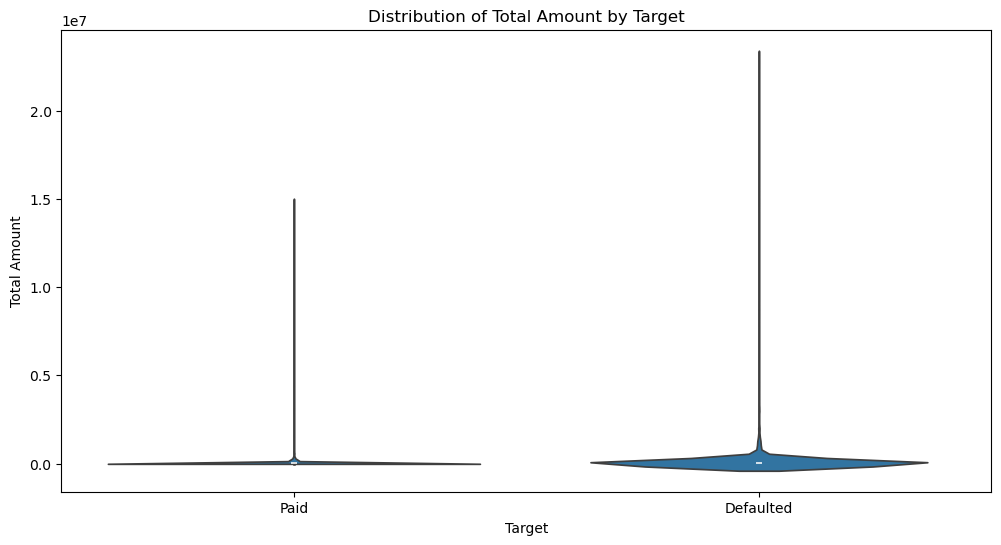

In [132]:
# Create a violin plot for the distribution of Total_Amount by target
plt.figure(figsize=(12, 6))
sns.violinplot(x='target', y='Total_Amount', data=train)
plt.xlabel('Target')
plt.ylabel('Total Amount')
plt.title('Distribution of Total Amount by Target')
plt.xticks(ticks=[0, 1], labels=['Paid', 'Defaulted'])
plt.show()

#### Target by Interest and fees

In [136]:
train["interest_and_fees"] = train["Lender_portion_to_be_repaid"] - train["Amount_Funded_By_Lender"]
interest_and_fees_description_by_target = train.groupby("target")["interest_and_fees"].describe()
interest_and_fees_description_by_target["count"] = interest_and_fees_description_by_target["count"].apply(lambda x: humanize.intcomma(int(x)))
interest_and_fees_description_by_target["max"] = interest_and_fees_description_by_target["max"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["min"] = interest_and_fees_description_by_target["min"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["mean"] = interest_and_fees_description_by_target["mean"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["std"] = interest_and_fees_description_by_target["std"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["25%"] = interest_and_fees_description_by_target["25%"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["50%"] = interest_and_fees_description_by_target["50%"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target["75%"] = interest_and_fees_description_by_target["75%"].apply(lambda x: humanize.intword(x))
interest_and_fees_description_by_target.set_index([["Paid", "Defaulted"]], inplace=True)
interest_and_fees_description_by_target

,count,mean,std,min,25%,50%,75%,max
Paid,"67,396",72,1.2 thousand,0,0,2,29,135.0 thousand
Defaulted,"1,258",1.9 thousand,9.1 thousand,0,120,370,1.1 thousand,221.3 thousand


- The average  interest and fees on defaulted loans (**1.9 thousand with a std of 9.1 thousand**) is much higher than on paid loans (**72 with a std of 1.2 thousand**);
- 

#### Target by loan type

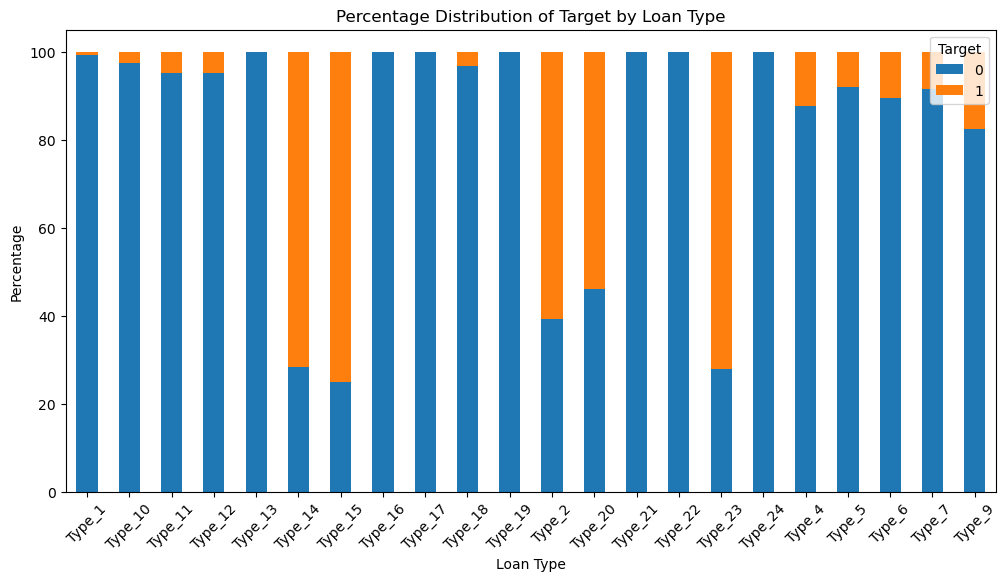

In [134]:
# Calculate the percentage distribution of target by loan_type
loan_type_target_distribution = train.groupby('loan_type')['target'].value_counts(normalize=True).unstack() * 100

# Create a bar plot for the percentage distribution of target by loan_type
loan_type_target_distribution.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Loan Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Target by Loan Type')
plt.xticks(rotation=45)
plt.legend(title='Target', loc='upper right')
plt.show()

- `Type_14`, `Type_15`, `Type_2`, `Type_20`, `Type_23` have high default probability rate (above 50%);
- `Type_1`, `Type_9-10`, `Type_11`, `Type_12`, `Type_18`, `Types_4-7` have low default probability rates (below 15%);
- `Type_13`, `Type_16-17`, `Type_19`, `Type_21-22`, and `Type_24` have a default probability of 0%;

#### Target by disbursement date

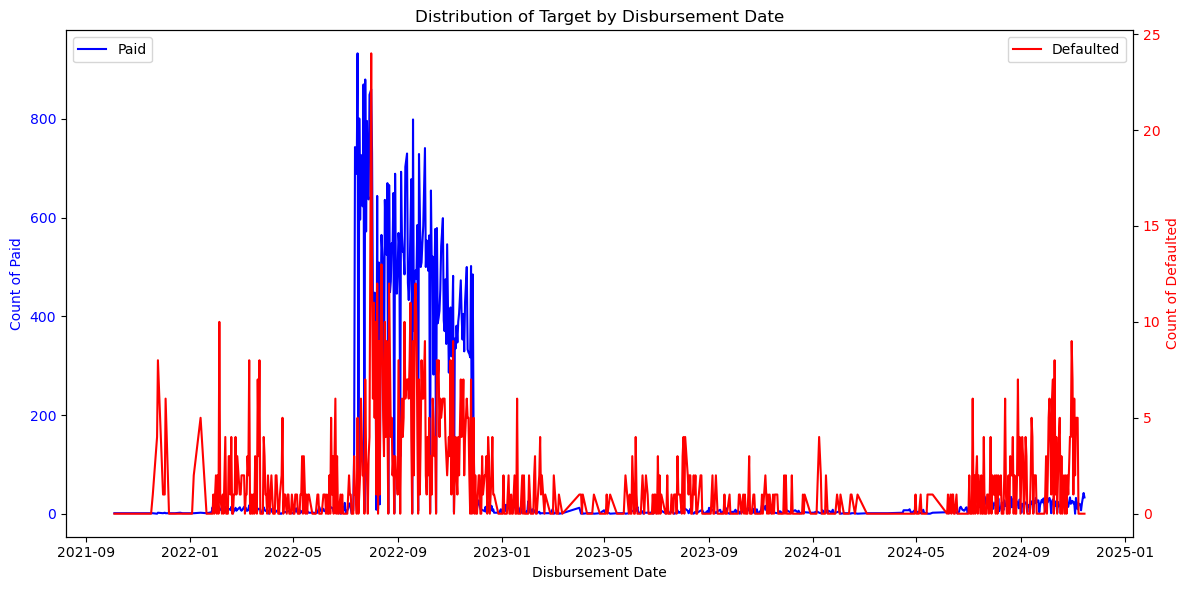

In [139]:

#  Group by disbursement_date and target, and count the occurrences
disbursement_target_distribution = train.groupby(['disbursement_date', 'target']).size().unstack(fill_value=0)

# Create a plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot target = 0 on the first y-axis
ax1.plot(disbursement_target_distribution.index, disbursement_target_distribution[0], color='blue', label='Paid')
ax1.set_xlabel('Disbursement Date')
ax1.set_ylabel('Count of Paid', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis
ax2 = ax1.twinx()
# Plot target = 1 on the second y-axis
ax2.plot(disbursement_target_distribution.index, disbursement_target_distribution[1], color='red', label='Defaulted')
ax2.set_ylabel('Count of Defaulted', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('Distribution of Target by Disbursement Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [142]:
disbursement_date_description_by_target = train.groupby("target")["disbursement_date"].describe()
disbursement_date_description_by_target["count"] = disbursement_date_description_by_target["count"].apply(lambda x: humanize.intcomma(int(x)))
disbursement_date_description_by_target["mean"] = disbursement_date_description_by_target["mean"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target["min"] = disbursement_date_description_by_target["min"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target["max"] = disbursement_date_description_by_target["max"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target["25%"] = disbursement_date_description_by_target["25%"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target["50%"] = disbursement_date_description_by_target["50%"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target["75%"] = disbursement_date_description_by_target["75%"].apply(lambda x: humanize.naturaldate(x))
disbursement_date_description_by_target.set_index([["Paid", "Defaulted"]], inplace=True)
disbursement_date_description_by_target

,count,mean,min,25%,50%,75%,max
Paid,"67,396",Oct 15 2022,Oct 04 2021,Aug 10 2022,Sep 16 2022,Oct 22 2022,Nov 14
Defaulted,"1,258",Feb 15 2023,Nov 18 2021,Aug 07 2022,Oct 08 2022,Aug 01 2023,Nov 06


#### Target by duration

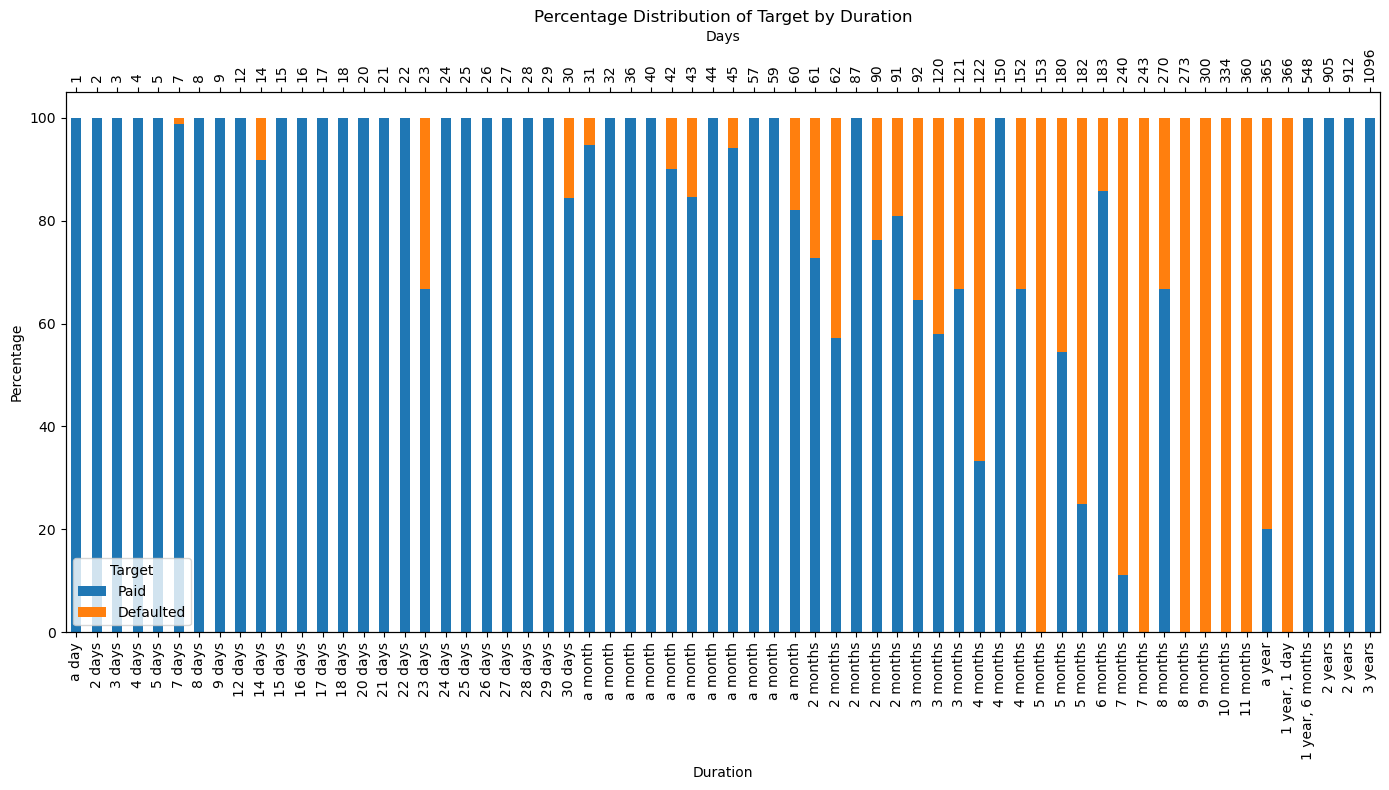

In [160]:
# Calculate the percentage distribution of target by duration
duration_target_distribution = train.groupby('duration')['target'].value_counts(normalize=True).unstack() * 100

# Create a bar plot for the percentage distribution of target by duration
fig, ax1 = plt.subplots(figsize=(14, 8))
duration_target_distribution.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel('Duration')
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage Distribution of Target by Duration')
ax1.set_xticklabels(pd.Series(duration_target_distribution.index).apply(lambda x: humanize.naturaldelta(dt.timedelta(days=x))), rotation=90)
ax1.legend(title='Target', loc='lower left', labels=['Paid', 'Defaulted'])

# Create a secondary x-axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(ax1.get_xticks())
ax2.set_xticklabels(duration_target_distribution.index, rotation=90)
ax2.set_xlabel('Days')

plt.tight_layout()
plt.show()

- Loans given for a duration of less than a month and above 1 year have a default probability rate below `20%`;
- Loans given for a duration between 2 months and 1 year, have default probability rate ranging from `20 to 100%` with exceptions occurring for 6 months(less than 10%), 4 months(150 days, 0%), and 90-91 days.
- Overall, for duration less than 1 year, the default probability rate increases

#### Target by Portion funded by lender

In [163]:
# Create a violin plot for the distribution of Lender_portion_Funded by target
fig = px.violin(train, x='target', y='Lender_portion_Funded', 
                labels={'target': 'Target', 'Lender_portion_Funded': 'Lender Portion Funded (%)'},
                title='Distribution of Lender Portion Funded by Loan Default Status', box=True)
fig.update_layout(xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=['Paid', 'Defaulted']))
fig.show()

- The median percent funded by the  institution is 20% for defaulted loans and 30% for paid loans 

### Multivariate Analysis

#### Money Flow

In [ ]:
#Total_Amount_to_Repay = Total_Amount + Interest_and_fees_on_total_amount 
#Lender_portion_to_be_repaid = Total_Amount_to_Repay * Lender_portion_Funded
#Lender_portion_to_be_repaid = Amount_Funded_By_Lender + Interest_and_fees_funded_by_lender
#Total_Amount = Amount_Funded_By_Lender + Lender_portion_Unfunded
train["Lender_portion_Unfunded"] = train["Total_Amount"] - train["Amount_Funded_By_Lender"]
train["Interest_and_fees_funded_by_lender"] = train["Lender_portion_to_be_repaid"] - train["Amount_Funded_By_Lender"]
train["Interest_and_fees_on_total_amount"] = train["Total_Amount_to_Repay"] - train["Total_Amount"]

In [174]:

# Define the nodes and links for the Sankey diagram
nodes = ["Total_Amount_to_Repay", "Total_Amount", "Interest_and_fees_on_total_amount", "Lender_portion_to_be_repaid", "Amount_Funded_By_Lender", "Interest_and_fees_funded_by_lender", "Lender_portion_Unfunded"]

# Create a mapping from node names to indices
node_indices = {node: i for i, node in enumerate(nodes)}

# Define the links
links = [
    {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Total_Amount"], "value": train["Total_Amount"].sum()},
    {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Interest_and_fees_on_total_amount"], "value": train["Interest_and_fees_on_total_amount"].sum()},
    {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Amount_Funded_By_Lender"], "value": train["Amount_Funded_By_Lender"].sum()},
    {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Interest_and_fees_funded_by_lender"], "value": train["Interest_and_fees_funded_by_lender"].sum()},
    {"source": node_indices["Total_Amount"], "target": node_indices["Amount_Funded_By_Lender"], "value": train["Amount_Funded_By_Lender"].sum()},
    {"source": node_indices["Total_Amount"], "target": node_indices["Lender_portion_Unfunded"], "value": train["Lender_portion_Unfunded"].sum()},
]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=[link["source"] for link in links],
        target=[link["target"] for link in links],
        value=[link["value"] for link in links]
    )
)])

fig.update_layout(title_text="Money Flow Sankey Diagram", font_size=10)
fig.show()

In [184]:

# Define the nodes
nodes = ["Total_Amount_to_Repay", "Total_Amount", "Interest_and_fees_on_total_amount", "Lender_portion_to_be_repaid", "Amount_Funded_By_Lender", "Interest_and_fees_funded_by_lender", "Lender_portion_Unfunded"]

# Create a mapping from node names to indices
node_indices = {node: i for i, node in enumerate(nodes)}

# Create subplots with domain type
fig = make_subplots(rows=2, cols=1, subplot_titles=["Paid (target=0)", "Defaulted (target=1)"], specs=[[{'type': 'domain'}], [{'type': 'domain'}]])

# Function to create links for a specific target
def create_links(target_data):
    return [
        {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Total_Amount"], "value": target_data["Total_Amount"].sum()},
        {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Interest_and_fees_on_total_amount"], "value": target_data["Interest_and_fees_on_total_amount"].sum()},
        {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Amount_Funded_By_Lender"], "value": target_data["Amount_Funded_By_Lender"].sum()},
        {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Interest_and_fees_funded_by_lender"], "value": target_data["Interest_and_fees_funded_by_lender"].sum()},
        {"source": node_indices["Total_Amount"], "target": node_indices["Amount_Funded_By_Lender"], "value": target_data["Amount_Funded_By_Lender"].sum()},
        {"source": node_indices["Total_Amount"], "target": node_indices["Lender_portion_Unfunded"], "value": target_data["Lender_portion_Unfunded"].sum()},
    ]

# Add Sankey diagrams for each target
for i, target in enumerate(train["target"].unique(), start=1):
    target_data = train[train["target"] == target]
    links = create_links(target_data)
    fig.add_trace(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes
        ),
        link=dict(
            source=[link["source"] for link in links],
            target=[link["target"] for link in links],
            value=[link["value"] for link in links]
        )
    ), row=i, col=1)

fig.update_layout(title_text="Money Flow Sankey Diagram by Target", font_size=10, height=800, width=800)
fig.show()

In [183]:
# Define the nodes
nodes = ["Total_Amount_to_Repay", "Total_Amount", "Interest_and_fees_on_total_amount", "Lender_portion_to_be_repaid", "Amount_Funded_By_Lender", "Interest_and_fees_funded_by_lender", "Lender_portion_Unfunded"]

# Create a mapping from node names to indices
node_indices = {node: i for i, node in enumerate(nodes)}

# Create subplots with domain type
fig = make_subplots(rows=4, cols=1, subplot_titles=[f"Lender {l}" for l in train["lender_id"].unique()], specs=[[{'type': 'domain'}], [{'type': 'domain'}], [{'type': 'domain'}], [{'type': 'domain'}]])

# Function to create links for a specific lender
def create_links(lender_data):
    return [
        {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Total_Amount"], "value": lender_data["Total_Amount"].sum()},
        {"source": node_indices["Total_Amount_to_Repay"], "target": node_indices["Interest_and_fees_on_total_amount"], "value": lender_data["Interest_and_fees_on_total_amount"].sum()},
        {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Amount_Funded_By_Lender"], "value": lender_data["Amount_Funded_By_Lender"].sum()},
        {"source": node_indices["Lender_portion_to_be_repaid"], "target": node_indices["Interest_and_fees_funded_by_lender"], "value": lender_data["Interest_and_fees_funded_by_lender"].sum()},
        {"source": node_indices["Total_Amount"], "target": node_indices["Amount_Funded_By_Lender"], "value": lender_data["Amount_Funded_By_Lender"].sum()},
        {"source": node_indices["Total_Amount"], "target": node_indices["Lender_portion_Unfunded"], "value": lender_data["Lender_portion_Unfunded"].sum()},
    ]

# Add Sankey diagrams for each lender
for i, lender_id in enumerate(train["lender_id"].unique(), start=1):
    lender_data = train[train["lender_id"] == lender_id]
    links = create_links(lender_data)
    fig.add_trace(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=nodes
        ),
        link=dict(
            source=[link["source"] for link in links],
            target=[link["target"] for link in links],
            value=[link["value"] for link in links]
        )
    ), row=i, col=1)

fig.update_layout(title_text="Money Flow Sankey Diagram by Lender", font_size=10, height=1200, width=800)
fig.show()